In [5]:
#import

from datetime import datetime
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [6]:
#pandas display settings

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [7]:
TODAY = datetime.today().strftime('%Y-%m-%d')
HDFS_RUCIO_LOCKS    = "/project/awg/cms/rucio/{}/locks/part*.avro".format(TODAY)

In [30]:
df_locks = spark.read.format('avro').load(HDFS_RUCIO_LOCKS) \
    .filter(F.col("STATE") == 'O') \
    .withColumnRenamed("NAME", "file_name") \
    .withColumn('file_size', F.col('BYTES').cast(T.LongType())) \
    .withColumn('rule', F.lower(F.hex(F.col('RULE_ID')))) \
    .withColumn('rse_id', F.lower(F.hex(F.col('RSE_ID')))) \
    .withColumn('created_date', F.to_date(F.from_unixtime(F.col('created_at')/1000)))\
    .select(["file_name", "file_size", "rule", "rse_id", "account", "created_date"])

In [59]:
wmcore_data_age = df_locks\
                    .filter(F.col("account")=="wmcore_output")\
                    .withColumn("age_in_weeks", F.ceil(F.datediff(F.current_date(), F.col("created_date"))/7))\
                    .withColumn("age_in_months", F.ceil(F.datediff(F.current_date(), F.col("created_date"))/30))\
                    .groupBy("age_in_months").sum("file_size")

In [49]:
wmcore_data_age.show(10, False)

+-----------+----------------+
|age_in_days|sum(file_size)  |
+-----------+----------------+
|29         |697423306249988 |
|26         |599238445226605 |
|65         |244955588200458 |
|54         |1904934008598425|
|0          |22455011106007  |
|22         |1729629572020576|
|7          |1119593744784498|
|77         |792858030671521 |
|34         |688038669838383 |
|50         |354679310284537 |
+-----------+----------------+
only showing top 10 rows



In [54]:
pd_wmcore_age = wmcore_data_age.sort("age_in_weeks").toPandas()

<AxesSubplot:xlabel='age_in_weeks'>

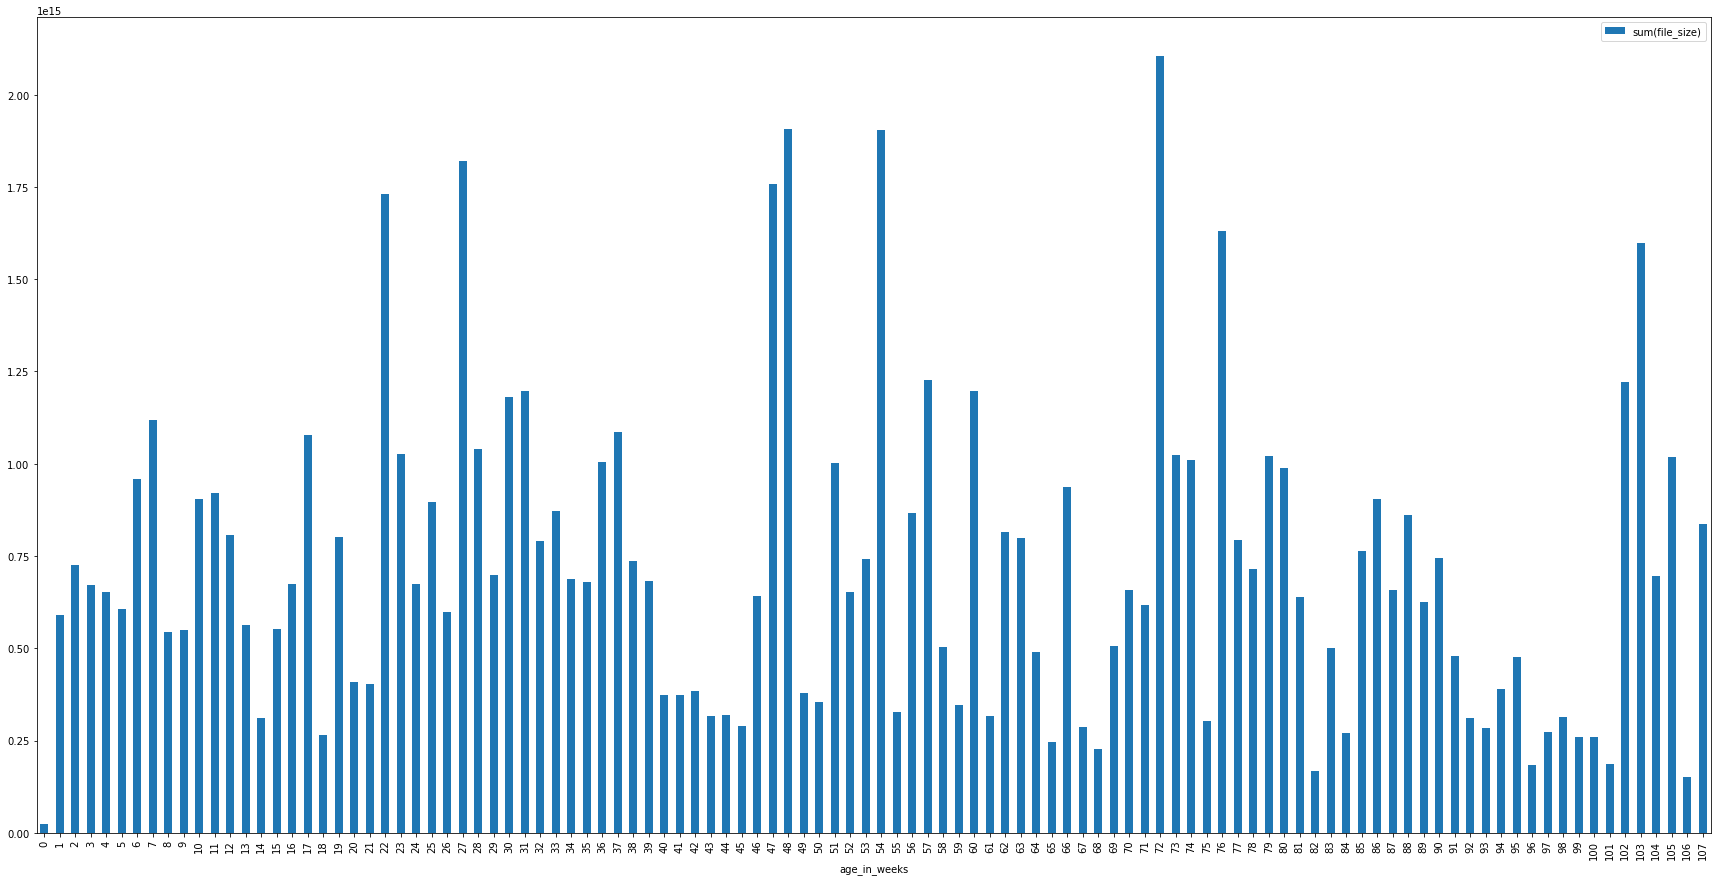

In [56]:
pd_wmcore_age.plot.bar(x="age_in_weeks", y="sum(file_size)", figsize=(30, 15))

<AxesSubplot:xlabel='age_in_months'>

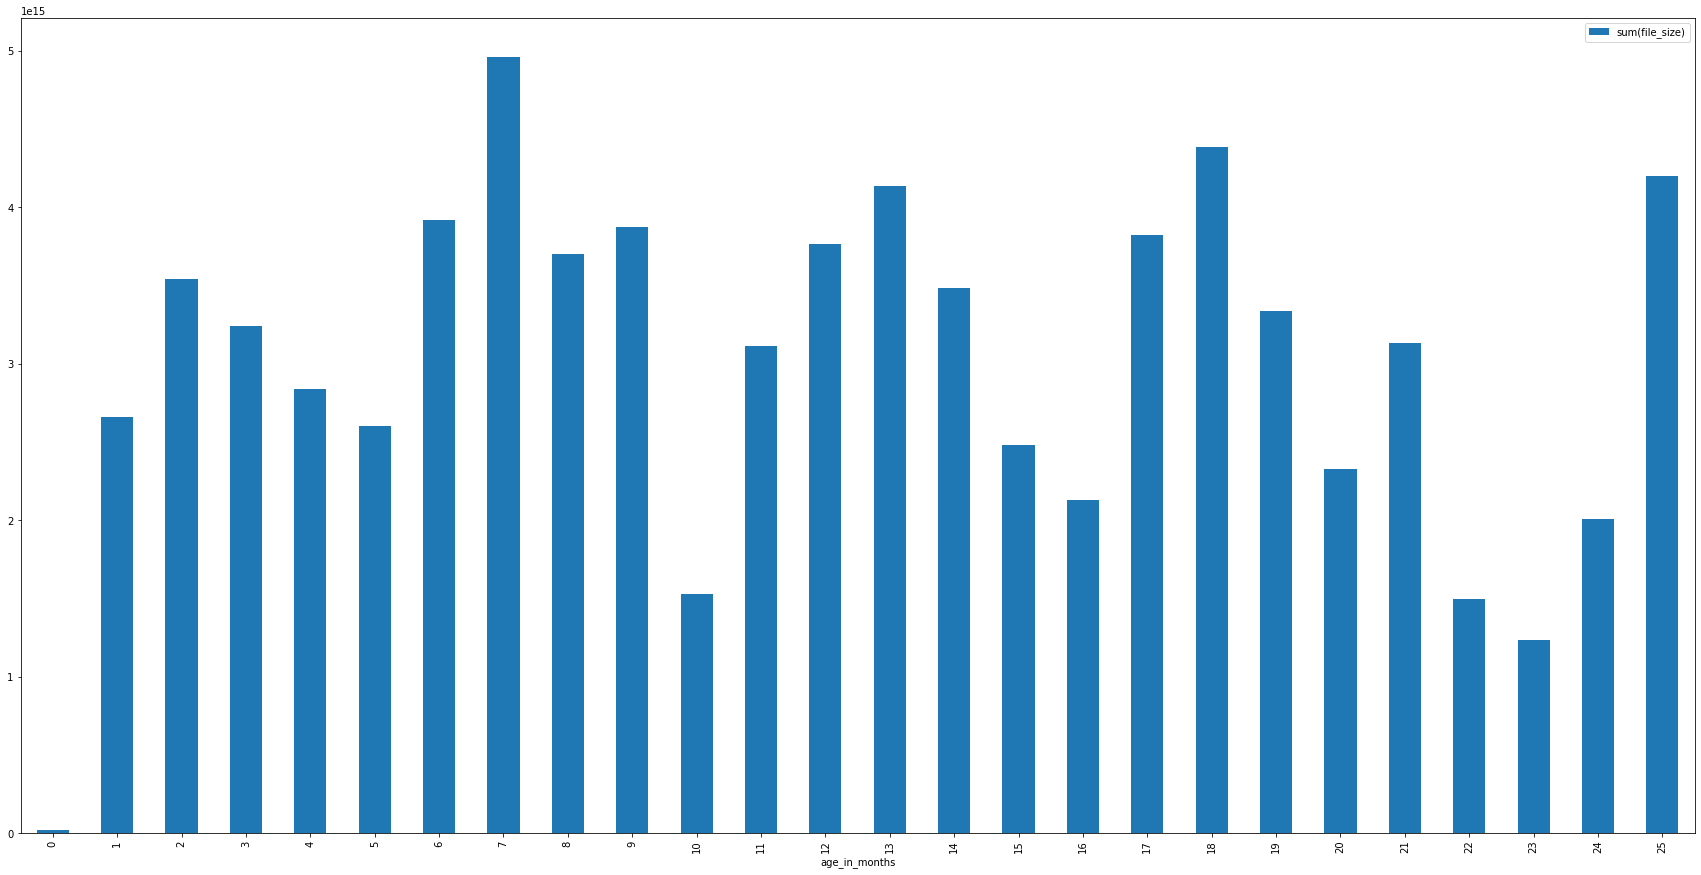

In [60]:
pd_wmcore_age_months = wmcore_data_age.sort("age_in_months").toPandas()
pd_wmcore_age_months.plot.bar(x="age_in_months", y="sum(file_size)", figsize=(30, 15))